In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import yaml

/gpfs3/well/clifton/users/wra194/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load features & outcomes

In [2]:
# Load features & outcomes
features = pd.read_feather('../data/processed/showcase_processed.feather')
outcomes = pd.read_feather('../data/processed/surv_outcomes_crc.feather')

# Only select features for individuals included in outcomes (i.e. following exclusion criteria)
features = features[features['eid'].isin(outcomes['eid'])]

In [3]:
# Cox negative log likelihood loss function can only be fed one y column, so have to encode censored individuals as negative T.
# See https://github.com/xiaonanl1996/MLforBrCa/blob/main/Scripts/Stats_Analysis/JupyterNotebook/XGBoost-Cox.ipynb (Thanks!)
outcomes.loc[outcomes['E'] == 0, 'T'] = -outcomes['T']

In [4]:
# Train test split, ensuring row:row match between features & outcomes (by ordering both by ID)
X_train, X_test, y_train, y_test = train_test_split(features.sort_values(by='eid'), outcomes.sort_values(by='eid'), test_size=.2, random_state=42)

In [5]:
dtrain = xgb.DMatrix(X_train.drop(columns='eid'), label=y_train['T'], enable_categorical=True)
dtest = xgb.DMatrix(X_test.drop(columns='eid'), label=y_test['T'], enable_categorical=True)

In [6]:
print("Training features shape: ", X_train.drop(columns='eid').shape)
print(f"DMatrix shape: ({dtrain.num_row()}, {dtrain.num_col()})")

Training features shape:  (399891, 1597)
DMatrix shape: (399891, 1597)


## Run basic XGBoost
For now, just use basic model with final hyperparameters from <a href='https://doi.org/10.1038/s41598-023-36214-0'>Liu 2023</a>. Hyperparameter tuning to come.

In [7]:
params = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'eta': 0.01,
    'max_depth': 2,
    'min_child_weight': 3, 
    'gamma': 1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    'lambda': 20,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda',
}

model = xgb.train(params, dtrain, 
    num_boost_round=50000,
    evals=[(dtest, "test")],
    early_stopping_rounds=200,
    verbose_eval=100)

[0]	test-cox-nloglik:10.99339
[100]	test-cox-nloglik:10.83885
[200]	test-cox-nloglik:10.77946
[300]	test-cox-nloglik:10.74625
[400]	test-cox-nloglik:10.72564
[500]	test-cox-nloglik:10.71303
[600]	test-cox-nloglik:10.70330
[700]	test-cox-nloglik:10.69675
[800]	test-cox-nloglik:10.69256
[900]	test-cox-nloglik:10.68971
[1000]	test-cox-nloglik:10.68685
[1100]	test-cox-nloglik:10.68477
[1200]	test-cox-nloglik:10.68254
[1300]	test-cox-nloglik:10.68117
[1400]	test-cox-nloglik:10.67968
[1500]	test-cox-nloglik:10.67886
[1600]	test-cox-nloglik:10.67766
[1700]	test-cox-nloglik:10.67689
[1800]	test-cox-nloglik:10.67612
[1900]	test-cox-nloglik:10.67537
[2000]	test-cox-nloglik:10.67504
[2100]	test-cox-nloglik:10.67439
[2200]	test-cox-nloglik:10.67320
[2300]	test-cox-nloglik:10.67253
[2400]	test-cox-nloglik:10.67218
[2500]	test-cox-nloglik:10.67158
[2600]	test-cox-nloglik:10.67130
[2700]	test-cox-nloglik:10.67076
[2800]	test-cox-nloglik:10.67035
[2900]	test-cox-nloglik:10.67014
[3000]	test-cox-nlogli

In [8]:
# Save model
model.save_model('../output/models/simple_model.ubj')

## Assess overfitting
Compute Harrell's C index for train and test sets

In [9]:
# Compute estimated risk scores
risk_scores_train = model.predict(dtrain)
risk_scores_test = model.predict(dtest)

In [10]:
# Make censored times positive again (had to make negative for input to XGBoost)
y_train.loc[y_train['E'] == 0, 'T'] = -y_train['T']
y_test.loc[y_test['E'] == 0, 'T'] = -y_test['T']

In [11]:
# In Cox, higher risk score (linear predictor) = higher hazard = shorter survival. In lifelines library, larger predictor value = longer survival. 
# So make cox risk scores negative to fit this. Acceptable as there is a direct inverse relationship between risk score and survival (so preserved rankign).
c_index_train = concordance_index(event_times=y_train['T'], predicted_scores=-risk_scores_train, event_observed=y_train['E'])
print("Train C-index:", c_index_train)

c_index_test = concordance_index(event_times=y_test['T'], predicted_scores=-risk_scores_test, event_observed=y_test['E'])
print("Test C-index:", c_index_test)

Train C-index: 0.7610562702224897
Test C-index: 0.7029978632954502


## SHAP values

In [12]:
# Set pretty names for features. Format: Feature title (UKB feature ID)
fields_metadata = pd.read_csv('../data/raw/ukb_metadata/field.txt', sep='\t')
pretty_names = []
for col in features.columns[1:]:
    field_id = int(col.split('.')[0])
    field_title = fields_metadata.loc[fields_metadata['field_id'] == field_id, 'title'].tolist()[0]
    # If one-hot-encoded multi-choice, set field title + choice
    if '_' in col:
        pretty_names.append(field_title + f" ({field_id}): {col.split('_')[1]}")
    # Otherwise just set to field title
    else:
        pretty_names.append(field_title + f" ({field_id})")

In [13]:
# Compute SHAP values. For some reason, throws additivity error/warning when using GPU, so set check_additivity=False for now.
explainer = shap.Explainer(model, feature_names=pretty_names)
shap_values = explainer(dtrain, check_additivity=False)

In [14]:
# Save SHAP values: convert to DF and save as feather file
shap_df = pd.DataFrame(shap_values.values, columns=pretty_names)
shap_df.to_feather("../output/models/simple_model_shap.feather")

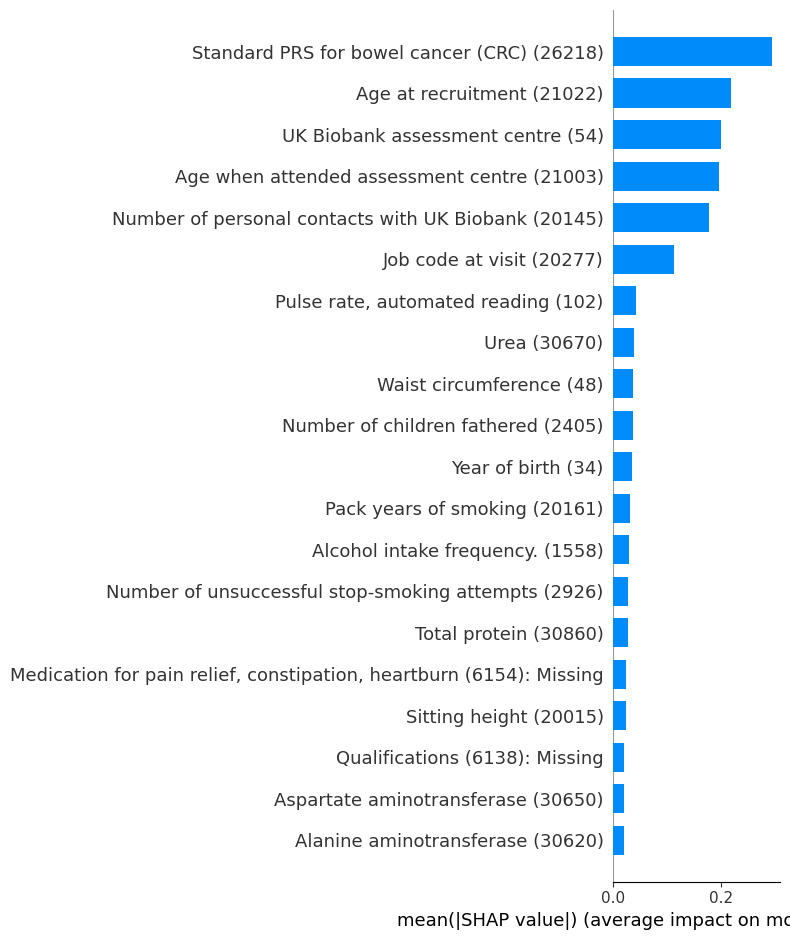

In [15]:
shap.summary_plot(shap_values, plot_type="bar", max_display=20)

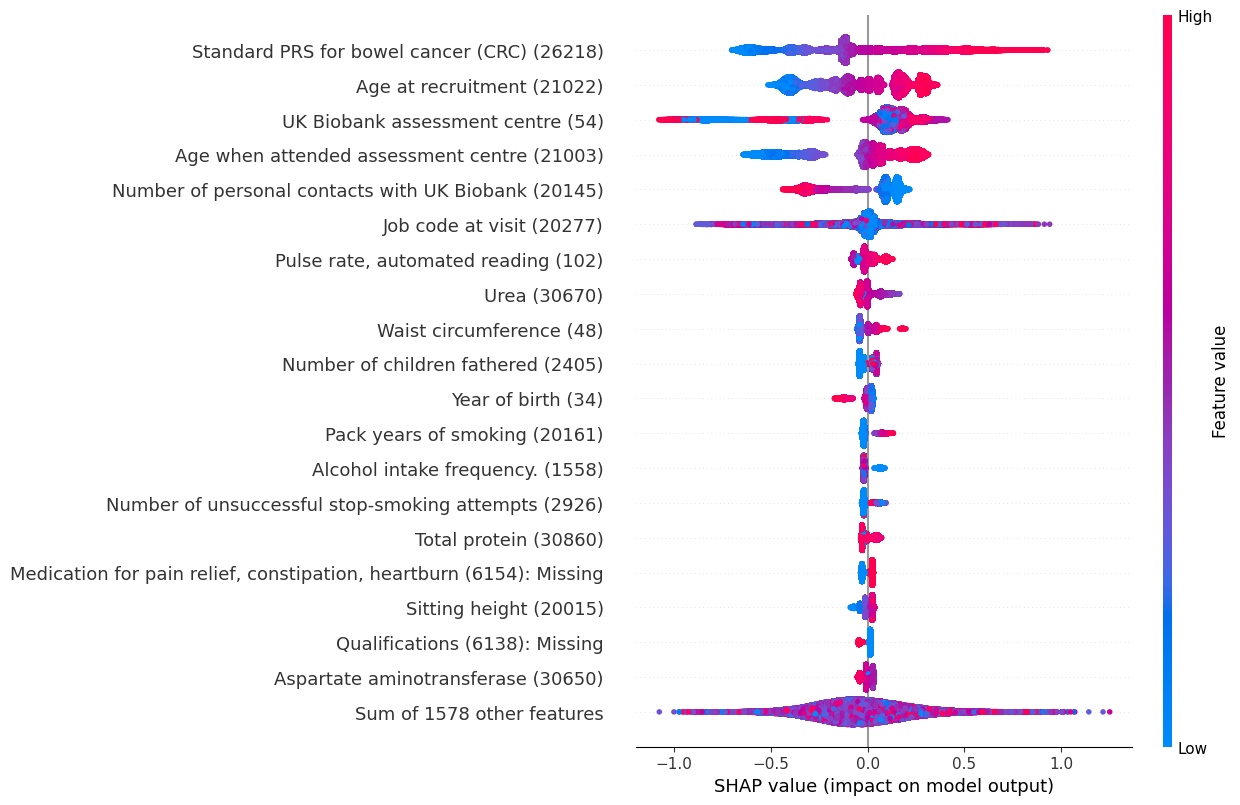

In [16]:
shap.plots.beeswarm(shap_values, max_display=20)